# Mamba simplified explanation: theory
### This is an adaptation of the original [work](https://github.com/hkproj/mamba-notes/blob/main/Mamba_Slides.pdf) by Umar Jamil, and his [video](https://www.youtube.com/watch?v=8Q_tqwpTpVU)

Author: Pavel Nakaznenko

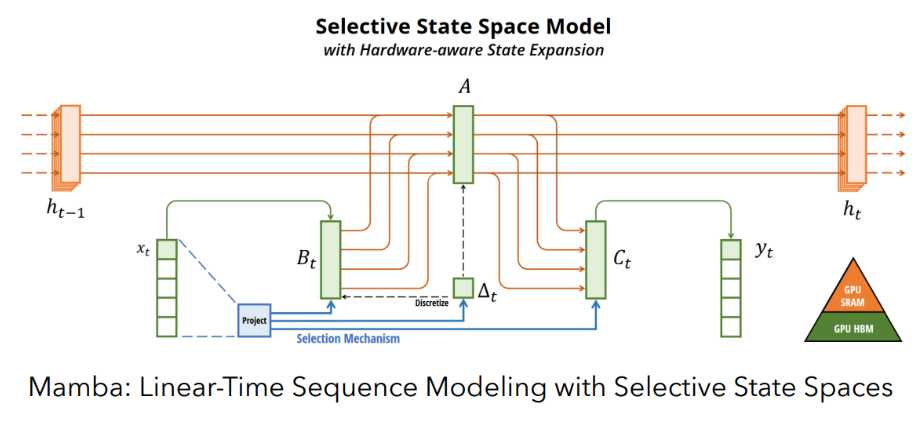

## 1. Intro

[Original Paper](https://arxiv.org/abs/2312.00752)

[Original Implementation](https://github.com/state-spaces/mamba/tree/main)


Let's start with the problem statement and the origins of Mamba.

There's a task of processing sequences. For example, we want to solve the problem of natural language modeling by generating text.

A sequence can be processed in several ways:
1. RNN, i.e., using recurrent neural networks. Theoretically, it works for very large sequences, but in practice, there are problems: for example, it can't be parallelized (in the classic implementation), and the approach suffers from exploding/vanishing gradients.
2. CNN, i.e., using convolutional neural networks. Also works, even parallelizes well. The complexity of training and inference depends on the size of the kernel.
3. Using Transformer-based solutions. Parallelizes very well, the complexity of inference with KV-Cache grows linearly, but training is quite expensive O(N*N).
4. State Space Models. Imagine the task of processing sequences as a state space model. This model is at the heart of Mamba.

## 2. State Space Models

The term "State Space Models" originated from the concept of [State Space Representation](https://en.wikipedia.org/wiki/State-space_representation), which comes from Control Theory.

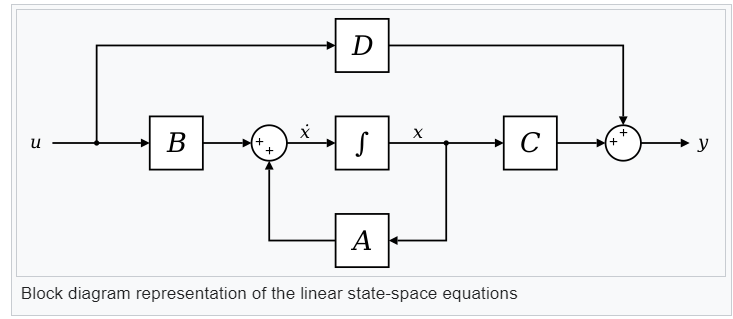

In simple terms, the concept is as follows:

We have a dynamic system that changes its state by processing input data in a certain way, returning some result. All these variables are interconnected linearly and through first-order differential equations.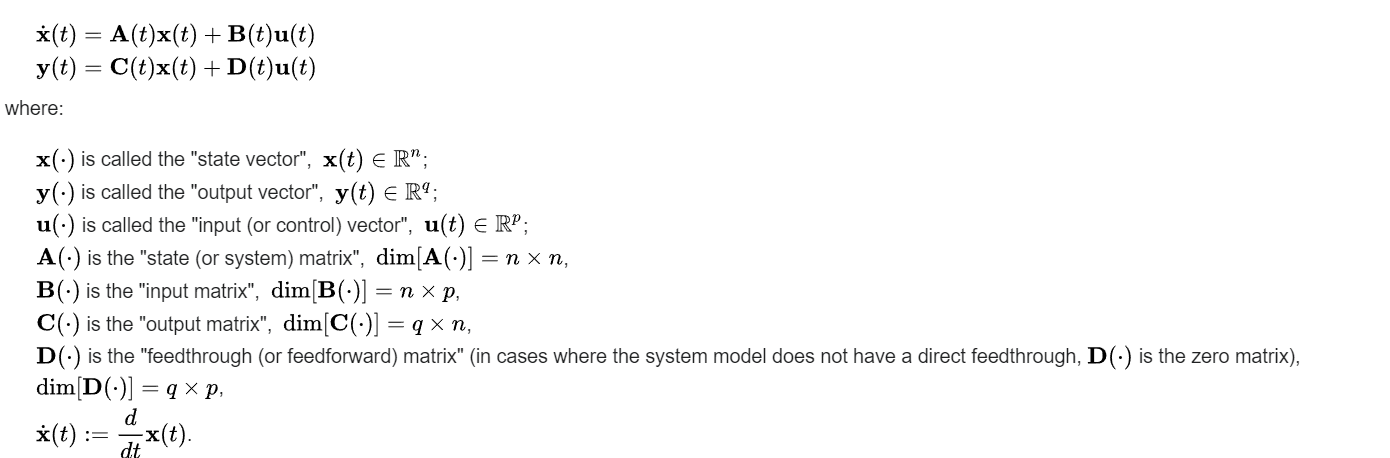To calculate the value of *y(t)* at any given time, we need to find the function *x(t)*, which describes the state of the system at any point in the entire time interval.

Solving this analytically is inconvenient and difficult. Moreover, in our case, we are dealing with a discrete signal, not a continuous one.

Therefore, we need to discretize our system.ы.

## 3. Discretization of the system

To avoid solving differential equations analytically, we can solve them using numerical methods. Various methods can be used for this, such as the [Euler method](https://en.wikipedia.org/wiki/Euler_method) or, in general, the [Runge-Kutta method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods).

Then, the discretized system will look like this:

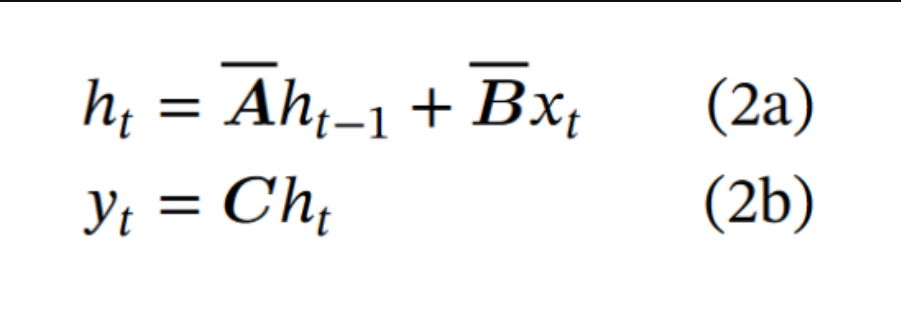

_Note_ that there's no term with the matrix *D* here, as it's assumed that the system does not contain a direct connection.

For discretization, the authors of the paper decided to use the _Zero-Order Hold_ method to discretize continuous values. The essence is that there are certain functions that transform matrices A and B according to some rule. In this case:

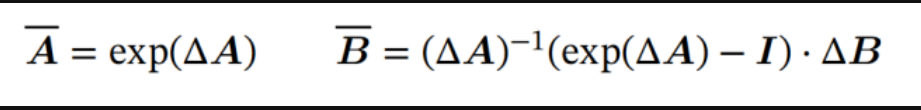

Here, the discretization step delta is not chosen manually but is learned by the network indeThus, we get a kinda recurrent model:get a quite re

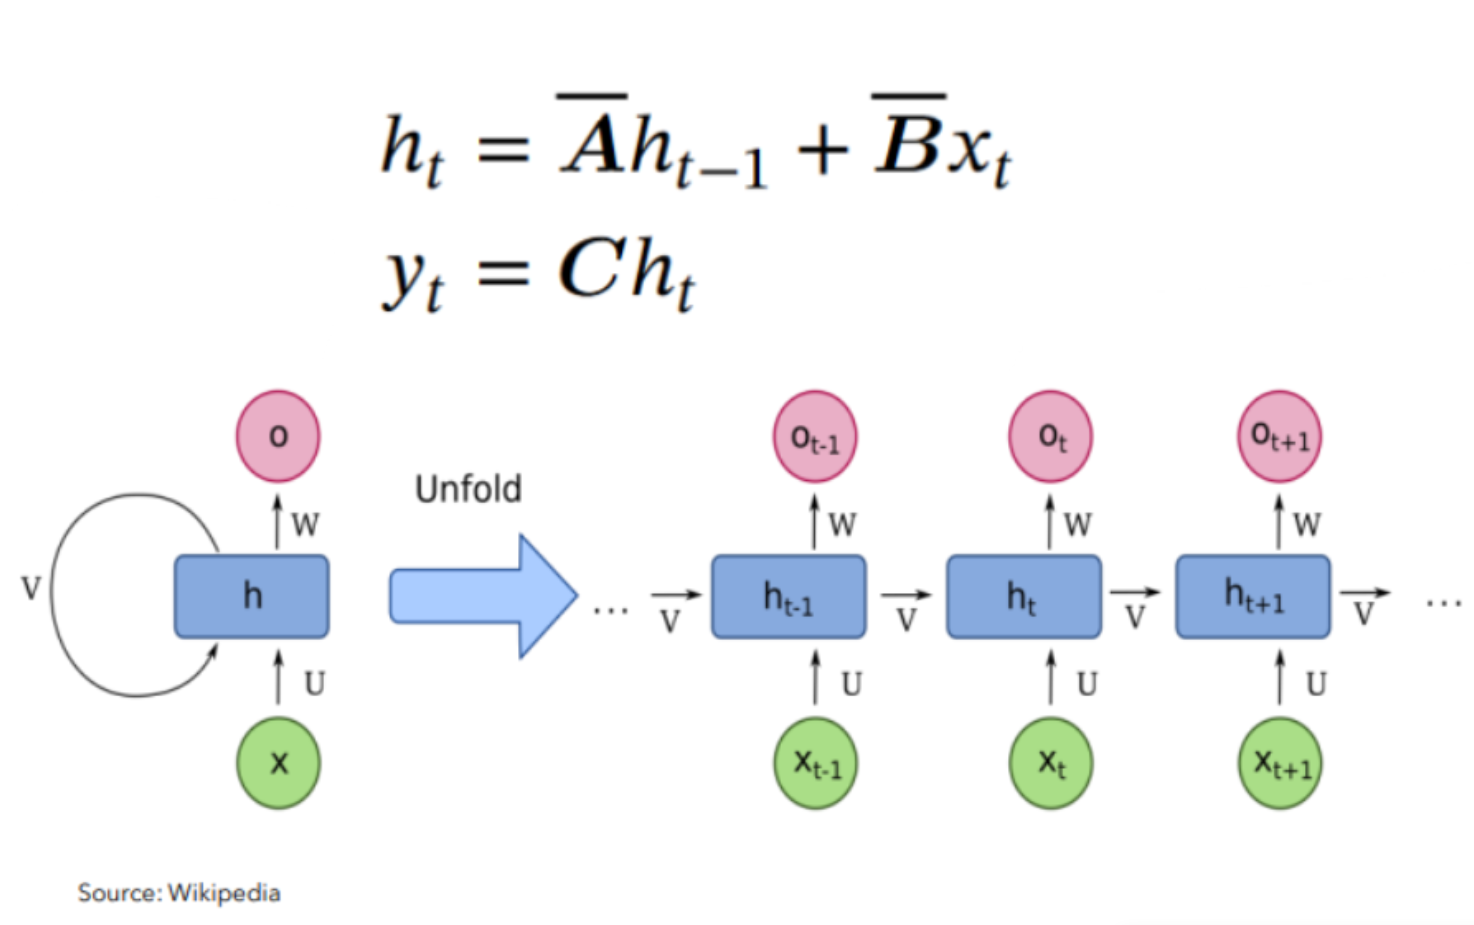

One could wonder: *"So this is almost like an RNN! What's the point?"*

A valid observation! Indeed, at this point, such a recurrent formulation is not significantly different from a typical recurrent network. And it has the same problems: for example, computations don't parallelize. However, here we are aided by a trick with convolution.h convolution.

## 4. Convolution

Let's look at how the values in our system are calculated sequentially starting from *t = 0*:

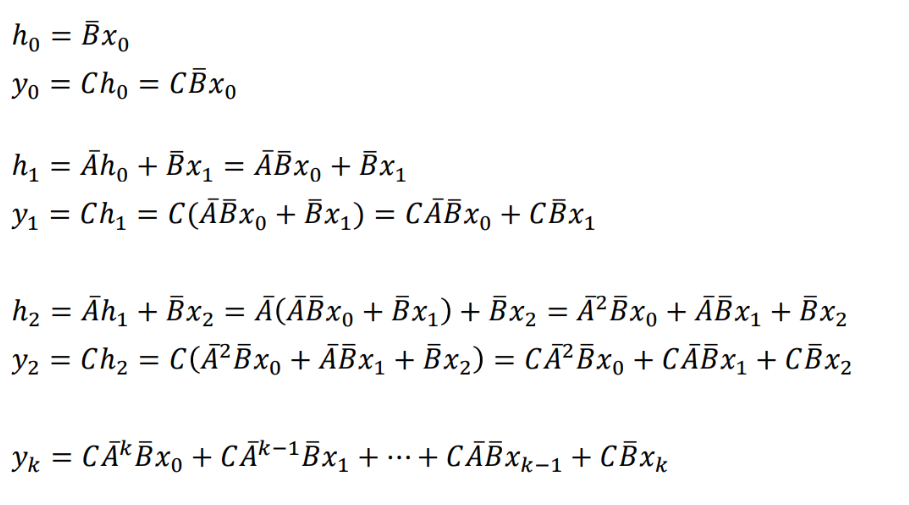

*"It's not hard to notice"* - Any teacher

that the expression

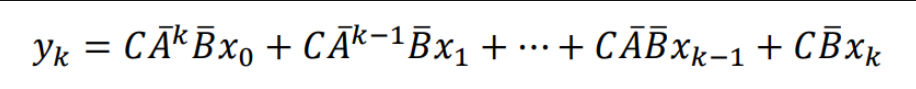

can be represented as a convolution operator:

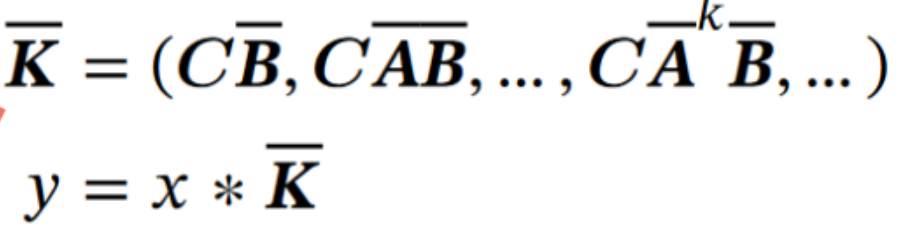

And convolutions, as we know, parallelize very well. Therefore:

1. During training, we use the convolution approach, effectively computing with parallel calculations.
2. During inference, it's enough to compute recurrently, without convolution, using a small constant amount of memory.

### A Very Important Nuance:
Such a _State Space Model_ in the implementation of [S4](https://srush.github.io/annotated-s4/) and subsequent versions is computed for each dimension of the input data.

That is, if we have an embedding with a dimension of 512 at the input, then we get 512 individual blocks. This can be perceived as a transformer with 512 attention heads.

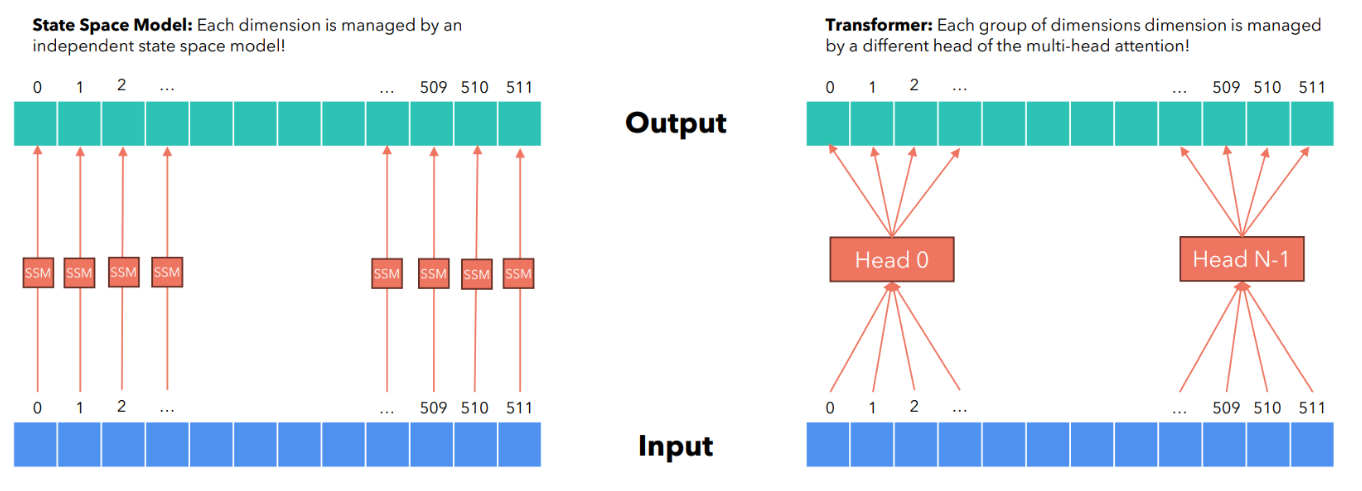

## 5. What are the А,В,С matrices?

To put it simply:
- The *A* matrix is responsible for processing the information from the past state and passing it forward.
- The *B* matrix is responsible for processing information from the current input and "mixing" it into the current state.
- The *C* matrix is responsible for processing information from the current state for the output result.

For the task of language modeling, the *A* matrix is very important, as it determines the dependency of the current token on the previous ones.

As it [turns out](https://arxiv.org/abs/2008.07669), SSMs (State Space Models) struggle with memory in their classic implementation due to gradient scaling, so the [HiPPO](https://arxiv.org/abs/2008.07669) technique was proposed.

The essence of the technique is this: We construct the *A* matrix for memorizing the incoming sequence in such a way that it contains coefficients for [Legendre polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials).

It's like performing a Fourier transform on the input signal for the entire sequence, only in a different domain. Here, we don't approximate the entire signal with the same accuracy, but give more "attention" to recent values compared to past ones.

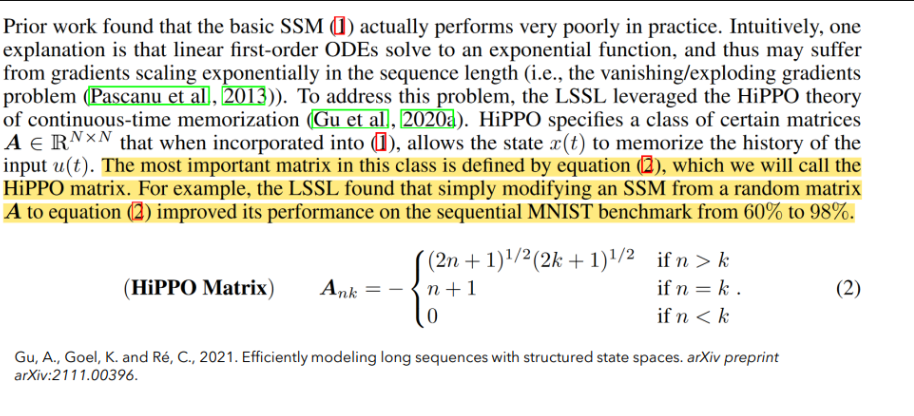

It all seems great, but there's a nuance.

# 6. S4 works only for some sequence modelling tasks

Indeed, the architecture we've described so far is not yet Mamba. It's [Structured State Space Model (S4)](https://arxiv.org/abs/2111.00396).

Although it performs well in copying or reproducing continuous segments of a sequence, this model is incapable of selective copying. For example, if we need to copy not a segment of 5 tokens but every fifth token, the model will struggle.

This limitation arises because our matrices *A, B,* and *C* depend on time (as a concept of sequence flow) but are not content-aware (in terms of understanding time flow). For the same reason, S4 models also lack the ability for induction.

And this is where the authors of Mamba step in!

# 7. Mamba (aka S6)

The authors proposed the following idea: let's sacrifice optimization via convolution, but in return, make the *B* and *C* matrices time-dependent and learn them during training.

Since we no longer have convolutions, to keep the algorithm fast and stable, we'll use a series of optimizations:
1. Instead of convolution, we now use the *scan* operation, which is mathematically equivalent to the previous application of convolution in S4 and is essentially a ["prefix sum"](https://en.wikipedia.org/wiki/Prefix_sum). The complexity of this calculation is *O(N)*.
2. The advantage of the prefix sum is that if the rule of associativity works, we can compute it in parallel (*parallel scan*), and the complexity becomes *O(N/T)*, where *T* is the number of working threads. The trick with parallel-computable prefix sums is quite old, probably about 20 years.
3. Kernel fusion - instead of constantly transferring calculation results between DRAM and SRAM, let's merge calculations into one operation so that we load from DRAM once, calculate everything in SRAM, and then unload back to DRAM only once.
4. To avoid repeatedly loading gradient values in the computation graph from DRAM to SRAM and back, the authors propose a trick for recalculating these gradients on the fly when needed.

Here's what Mamba looks like:

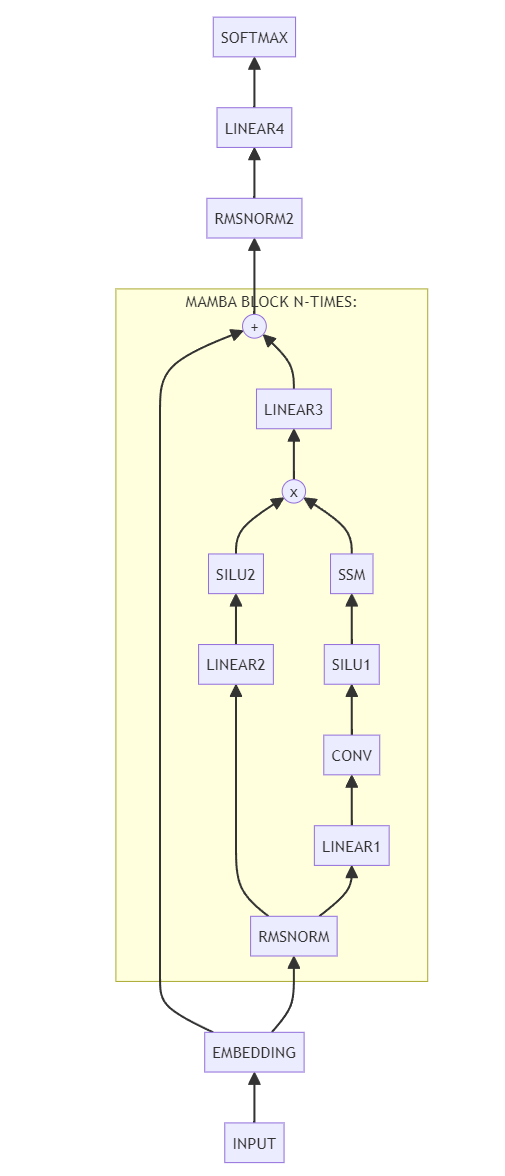

## 7. Result and performance

For more details, you can refer to the [original paper](https://arxiv.org/abs/2312.00752).

# 8. You are amazing! You really are.